### **EfficientNet VS ResNet**

##### Comparision Between the Two Models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Per session copy
!cp -r "/content/drive/MyDrive/green/all_dataset/test" /content/test


In [14]:
test_path = "/content/test/test"


##### Import Required Libraries

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, efficientnet_b0
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import precision_recall_fscore_support


In [15]:

image_size = 224
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to model weights
resnet_path = "/content/drive/MyDrive/green/all_dataset/models/best_resnet50_model.pth"
effnet_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"


# Transform
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


test_dataset = ImageFolder(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
class_names = test_dataset.classes


##### Model Comparisions

In [16]:
# EfficientNet
model_eff = efficientnet_b0(weights=None)
model_eff.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_eff.classifier[1].in_features, len(class_names))
)
model_eff.load_state_dict(torch.load(effnet_path, map_location=device))
model_eff.to(device).eval()

# ResNet-50
model_res = resnet50(weights=None)
model_res.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model_res.fc.in_features, len(class_names))
)
model_res.load_state_dict(torch.load(resnet_path, map_location=device))
model_res.to(device).eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:


def get_predictions(model, loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


labels_eff, preds_eff = get_predictions(model_eff, test_loader)
labels_res, preds_res = get_predictions(model_res, test_loader)


In [18]:

precision_eff, recall_eff, f1_eff, _ = precision_recall_fscore_support(labels_eff, preds_eff, average='macro')
precision_res, recall_res, f1_res, _ = precision_recall_fscore_support(labels_res, preds_res, average='macro')


##### Bar Chart of Precision, Recall, F1 Score of EfficientNet and ResNet

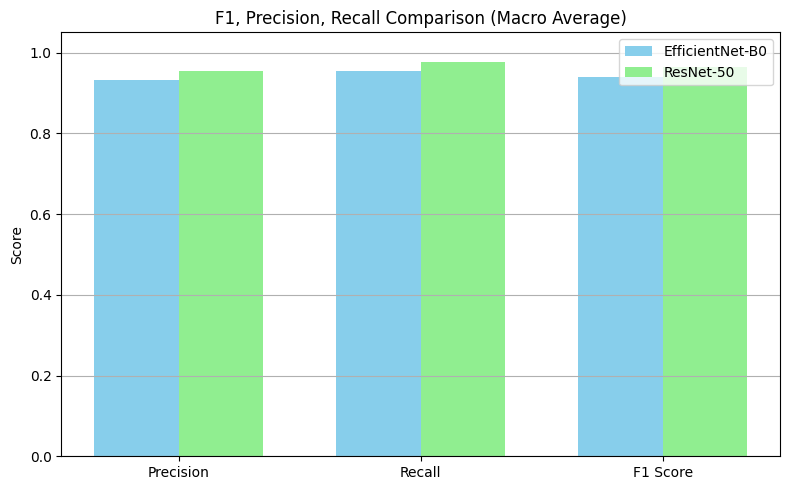

In [19]:
metrics = ['Precision', 'Recall', 'F1 Score']
eff_values = [precision_eff, recall_eff, f1_eff]
res_values = [precision_res, recall_res, f1_res]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, eff_values, width, label='EfficientNet-B0', color='skyblue')
plt.bar(x + width/2, res_values, width, label='ResNet-50', color='lightgreen')

plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("F1, Precision, Recall Comparison (Macro Average)")
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


##### Detailed Accuracy Results of both the Models

In [21]:
def evaluate_model(model, loader, name="Model"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n Classification Report for {name}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Run Evaluation for Both models
evaluate_model(model_eff, test_loader, "EfficientNet-B0")
evaluate_model(model_res, test_loader, "ResNet-50")



 Classification Report for EfficientNet-B0:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.87      0.90       126
                                 Apple___Black_rot       0.98      1.00      0.99       125
                          Apple___Cedar_apple_rust       0.93      1.00      0.96        55
                                   Apple___healthy       0.98      0.95      0.97       329
                               Blueberry___healthy       0.98      0.99      0.99       301
          Cherry_(including_sour)___Powdery_mildew       0.96      0.99      0.97       211
                 Cherry_(including_sour)___healthy       0.96      0.99      0.98       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.67      0.90      0.77       103
                       Corn_(maize)___Common_rust_       0.95      0.99      0.97       239
               Corn_(maize)___Nort